In [42]:
import os
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
import numpy as np

from stable_baselines import DQN
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy


from stable_baselines.common.callbacks import CheckpointCallback

from ads_utils import load_data, plot, Environment, write_to_logs, moving_average
from tqdm import tqdm

import time

In [25]:
EPOCHS = 200
INITIAL_BALANCE = 10_000
PAST_TICKS = 20

train_range = [i for i in range(24, 13-1, -1)]
train_data = load_data(train_range)

env_train = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

# separate instance
env_learn = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

val_range = [i for i in range(12, 7-1, -1)]
val_data = load_data(val_range)
env_val =  Environment(val_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

In [4]:
# model learn timesteps(10_000 * EPOCHS)
# use callback to save model!
start_time = time.time()

env_learn = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS, train=True)

model = DQN(MlpPolicy, env_learn, learning_rate=0.00001, batch_size=50, seed=1, verbose=0, double_q=True)

# callback for saving the model at each 10_000 steps
checkpoint_callback = CheckpointCallback(save_freq=10_000, save_path='./checkpoint_logs/',
                                         name_prefix='DQN_final')

model.learn(10_000*EPOCHS, callback=checkpoint_callback, log_interval=10_000)

print(time.time()-start_time)

3597.977014064789


In [5]:
start_time = time.time()
log_dir = "./checkpoint_logs/"
EPOCHS = 100

env_train = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

env_val =  Environment(val_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

train_portfolio_values = []
val_portfolio_values = []

for i in range(1, EPOCHS + 1): 
    
    # load each model
    path = log_dir + f"DQN_{i*10000}_steps"
    print(path)
    model = DQN.load(path)
    
    train_obs = env_train.reset(rand_start=False) # t=0
    for j in range(len(train_data)-PAST_TICKS-1):
        # predict on training
        action, _ = model.predict(train_obs)
        
        _, train_portfolio_value = env_train.get_data()
     
        train_obs, _, done, _ = env_train.step(action)
        
        if done:
            break
    train_portfolio_values.append(train_portfolio_value)
    
    # predict on validation
    val_obs = env_val.reset(rand_start=False) # t=0
    for j in range(len(val_data)-PAST_TICKS-1):

        action, _ = model.predict(val_obs)
       
        _, val_portfolio_value = env_val.get_data()

        val_obs, _, done, _ = env_val.step(action)

        if done:
            break
            
    val_portfolio_values.append(val_portfolio_value)
    
print(time.time()-start_time)

./checkpoint_logs/DQN_10000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_20000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_30000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_40000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_50000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_60000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_70000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_80000_steps
Loading

./checkpoint_logs/DQN_610000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_620000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_630000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_640000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_650000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_660000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_670000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_680000_steps

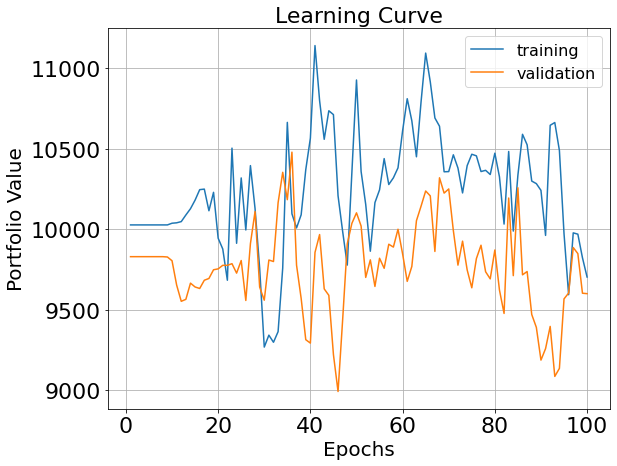

In [7]:
epoch_ranges = np.arange(1, EPOCHS+1)
fig, ax = plt.subplots(figsize=(9,7))
plt.plot(epoch_ranges, train_portfolio_values, label="training")
plt.plot(epoch_ranges, val_portfolio_values, label="validation")
plt.title("Learning Curve", fontsize=22)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=20)

plt.grid()
plt.legend(fontsize=16)
#plt.savefig("learning_curve_double_qn_latest")

## Second Run

In [ ]:
# model learn timesteps(10_000 * EPOCHS)
# use callback to save model!
EPOCHS = 500
start_time = time.time()

# the difference here is the train=false flag for env_learn
env_learn = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

model = DQN(MlpPolicy, env_learn, learning_rate=0.00001, batch_size=50, seed=1, verbose=0, double_q=True)
checkpoint_callback = CheckpointCallback(save_freq=10_000, save_path='./checkpoint_logs/DQN/',
                                         name_prefix='DQN')

# save at every 1k timestep
model.learn(10_000*EPOCHS, callback=checkpoint_callback, log_interval=1_000)

print(time.time()-start_time)

In [52]:
start_time = time.time()
model = DQN.load(path)
print(time.time()-start_time)

1.3106019496917725


In [53]:
start_time = time.time()
log_dir = "./checkpoint_logs/"

env_train = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

env_val =  Environment(val_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

train_portfolio_values = []
val_portfolio_values = []

for i in range(1, EPOCHS + 1): 
    path = log_dir + f"DQN_learn_{i*10000}_steps"
    print(path)
    model = DQN.load(path)
    
    train_obs = env_train.reset(rand_start=False) # t=0
    for j in range(len(train_data)-PAST_TICKS-1):
        # predict on training
        action, _ = model.predict(train_obs)
        
        _, train_portfolio_value = env_train.get_data()
     
        train_obs, _, done, _ = env_train.step(action)
        
        if done:
            break
    train_portfolio_values.append(train_portfolio_value)
    
    # predict on validation
    val_obs = env_val.reset(rand_start=False) # t=0
    for j in range(len(val_data)-PAST_TICKS-1):

        action, _ = model.predict(val_obs)
       
        _, val_portfolio_value = env_val.get_data()

        val_obs, _, done, _ = env_val.step(action)

        if done:
            break
            
    val_portfolio_values.append(val_portfolio_value)
    print(time.time()-start_time)
    break


./checkpoint_logs/DQN_learn_10000_steps
163.98849606513977


In [57]:
64/2

32.0

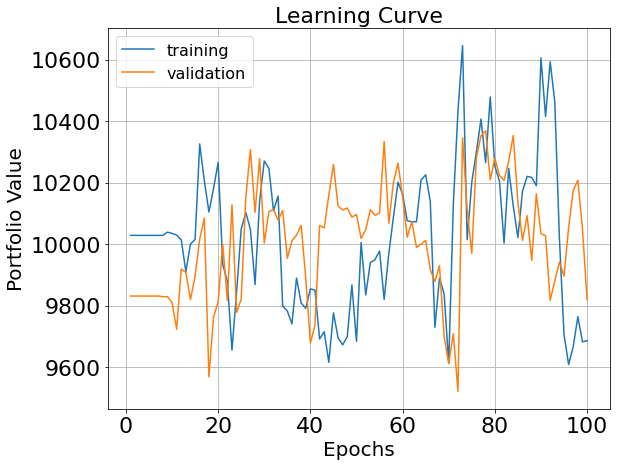

In [29]:
fig, ax = plt.subplots(figsize=(9,7))
plt.plot(epoch_ranges, train_portfolio_values, label="training")
plt.plot(epoch_ranges, val_portfolio_values, label="validation")
plt.title("Learning Curve", fontsize=22)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=20)
plt.grid()
plt.legend(fontsize=16)
plt.savefig("learning_curve_double_qn_without_train")

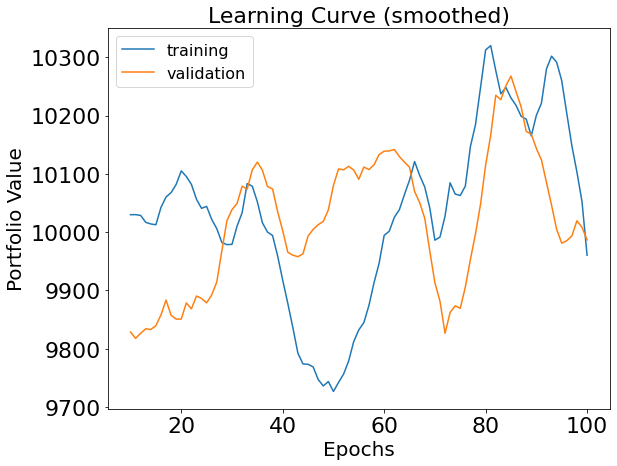

In [41]:
from ads_utils import moving_average
x = epoch_ranges
y = train_portfolio_values
y = moving_average(y, window=10)

# Truncate x
x = x[len(x) - len(y):]

#plots reward at each k timestep
fig, ax = plt.subplots(figsize=(9,7))
plt.plot(x, y, label="training")


x = epoch_ranges
y = val_portfolio_values
y = moving_average(y, window=10)

# Truncate x
x = x[len(x) - len(y):]
plt.plot(x, y, label="validation")

plt.title("Learning Curve (smoothed)", fontsize=22)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=20)

plt.legend(fontsize=16)
plt.savefig("smoothed_learning_curve")

In [39]:
len(train_data)

126030

In [63]:
path = f'./checkpoint_logs/DQN_{100_0000}_steps'

Loading a model without an environment, this model cannot be trained until it has a valid environment.


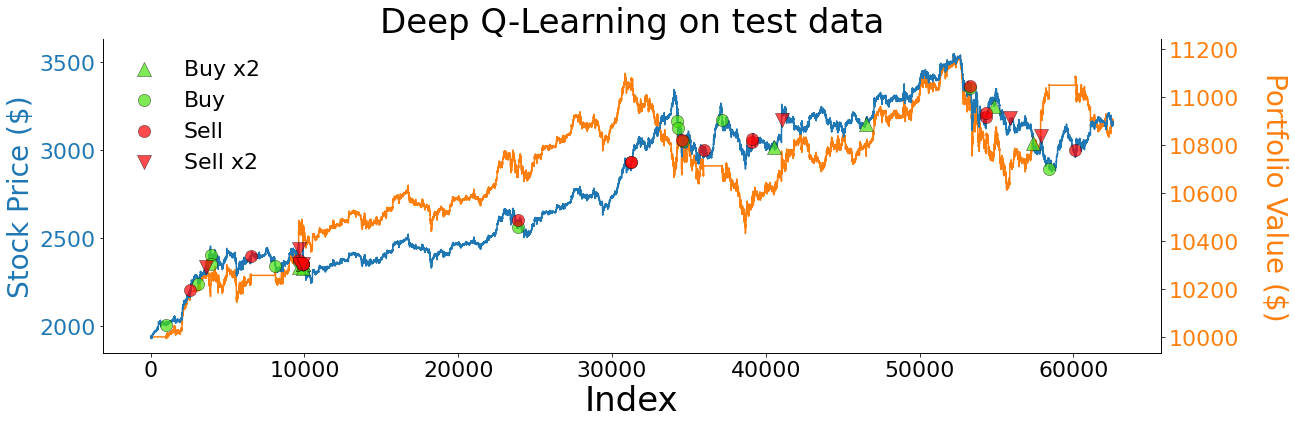

In [64]:
INITIAL_BALANCE = 10_000
PAST_TICKS = 20
SELL, HOLD, BUY = 0, 1, 2
test_range = [i for i in range(6, 1-1, -1)]
test_data = load_data(test_range)


env = Environment(test_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

model = DQN.load(path)

state = env.reset(rand_start=False)

portfolio_values = []
prices = []
actions = []

for i in range(len(test_data)):
    action, _ = model.predict(state)

    price, portfolio_value = env.get_data()
    
    actions.append(action)
    prices.append(price)
    
    portfolio_values.append(portfolio_value)

    state, reward, done, _ = env.step(action)
    
    if done:
        break
plot(prices, actions, portfolio_values, right_y_adjust=1.12, title="Deep Q-Learning on test data")